# A notebook for centgovspend

Lets first load our favourite tools

In [1]:
import pandas as pd
import os
import re
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import seaborn as sns
from clean_matches import clean_matches
import matplotlib as mpl
import gender_guesser.detector as gender
gendet = gender.Detector()
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
%load_ext autoreload
%autoreload 2

Then lets load the main payments and reconciliation datasets:

In [2]:
payments = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output', 'master',
                 'All_Merged_Unmatched.csv')),
    encoding="ISO-8859-1", sep=',', engine='python',
    dtype={'transactionnumber': str,
           'supplier': str,
           'date': str,
           'expensearea': str,
           'expensetype': str,
           'file': str})
payments['amount'] = pd.to_numeric(payments['amount'],
                                   errors='coerce')
payments = payments[~pd.isnull(payments['amount'])]
#payments = payments[payments['amount']>25000]
payments['date'] = payments['date'].apply(pd.to_datetime,
                                          dayfirst=True,
                                          errors = 'coerce')
payments = payments[~pd.isnull(payments['date'])]
payments = payments[~pd.isnull(payments['supplier'])]
replacedict = pd.read_csv((os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'support', 'dept_names_dict.csv'))),
                          header=None, dtype={0: str}).set_index(0).squeeze().to_dict()
for key, value in replacedict.items():
    payments['dept'] = payments['dept'].replace(key,value)
    
recon_sup = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output',
                 'master', 'Reconciled_Suppliers.tsv')),
    encoding="ISO-8859-1", sep='\t')
recon_sup = recon_sup.drop(['Disputed Office', 'Third Match',
                            'Third ID', 'Third Score'], axis=1)
matched = pd.merge(payments, recon_sup, how='left', left_on='supplier',
    right_on='RawSupplier').dropna(subset=['Best Match'])

How about some summary statistics?

In [3]:
print('We matched ' + str(len(matched)) + ' out of ' + str(len(payments)) +
      ' payments in total (' + str(round(((len(matched) /
                                           len(payments)) * 100), 2)) + '%).')
print('We matched £' + str(int(matched['amount'].sum())) + ' out of ' +
      '£' + str(int(payments['amount'].sum())) +
      ' value in total (' + str(int(round(((matched['amount'].sum() /
                                        payments['amount'].sum()) *
                                       100), 2))) + '%).')
print('We matched ' + str(len(matched['supplier'].unique())) + ' out of ' +
      str(len(payments['supplier'].unique())) +
      ' unique suppliers in total (' +
      str(round(((len(matched['supplier'].unique()) /
                  len(payments['supplier'].unique())) * 100), 2)) + '%).')

We matched 1973222 out of 2718202 payments in total (72.59%).
We matched £213537355177 out of £998659968686 value in total (21%).
We matched 27542 out of 60581 unique suppliers in total (45.46%).


How does this look over time?

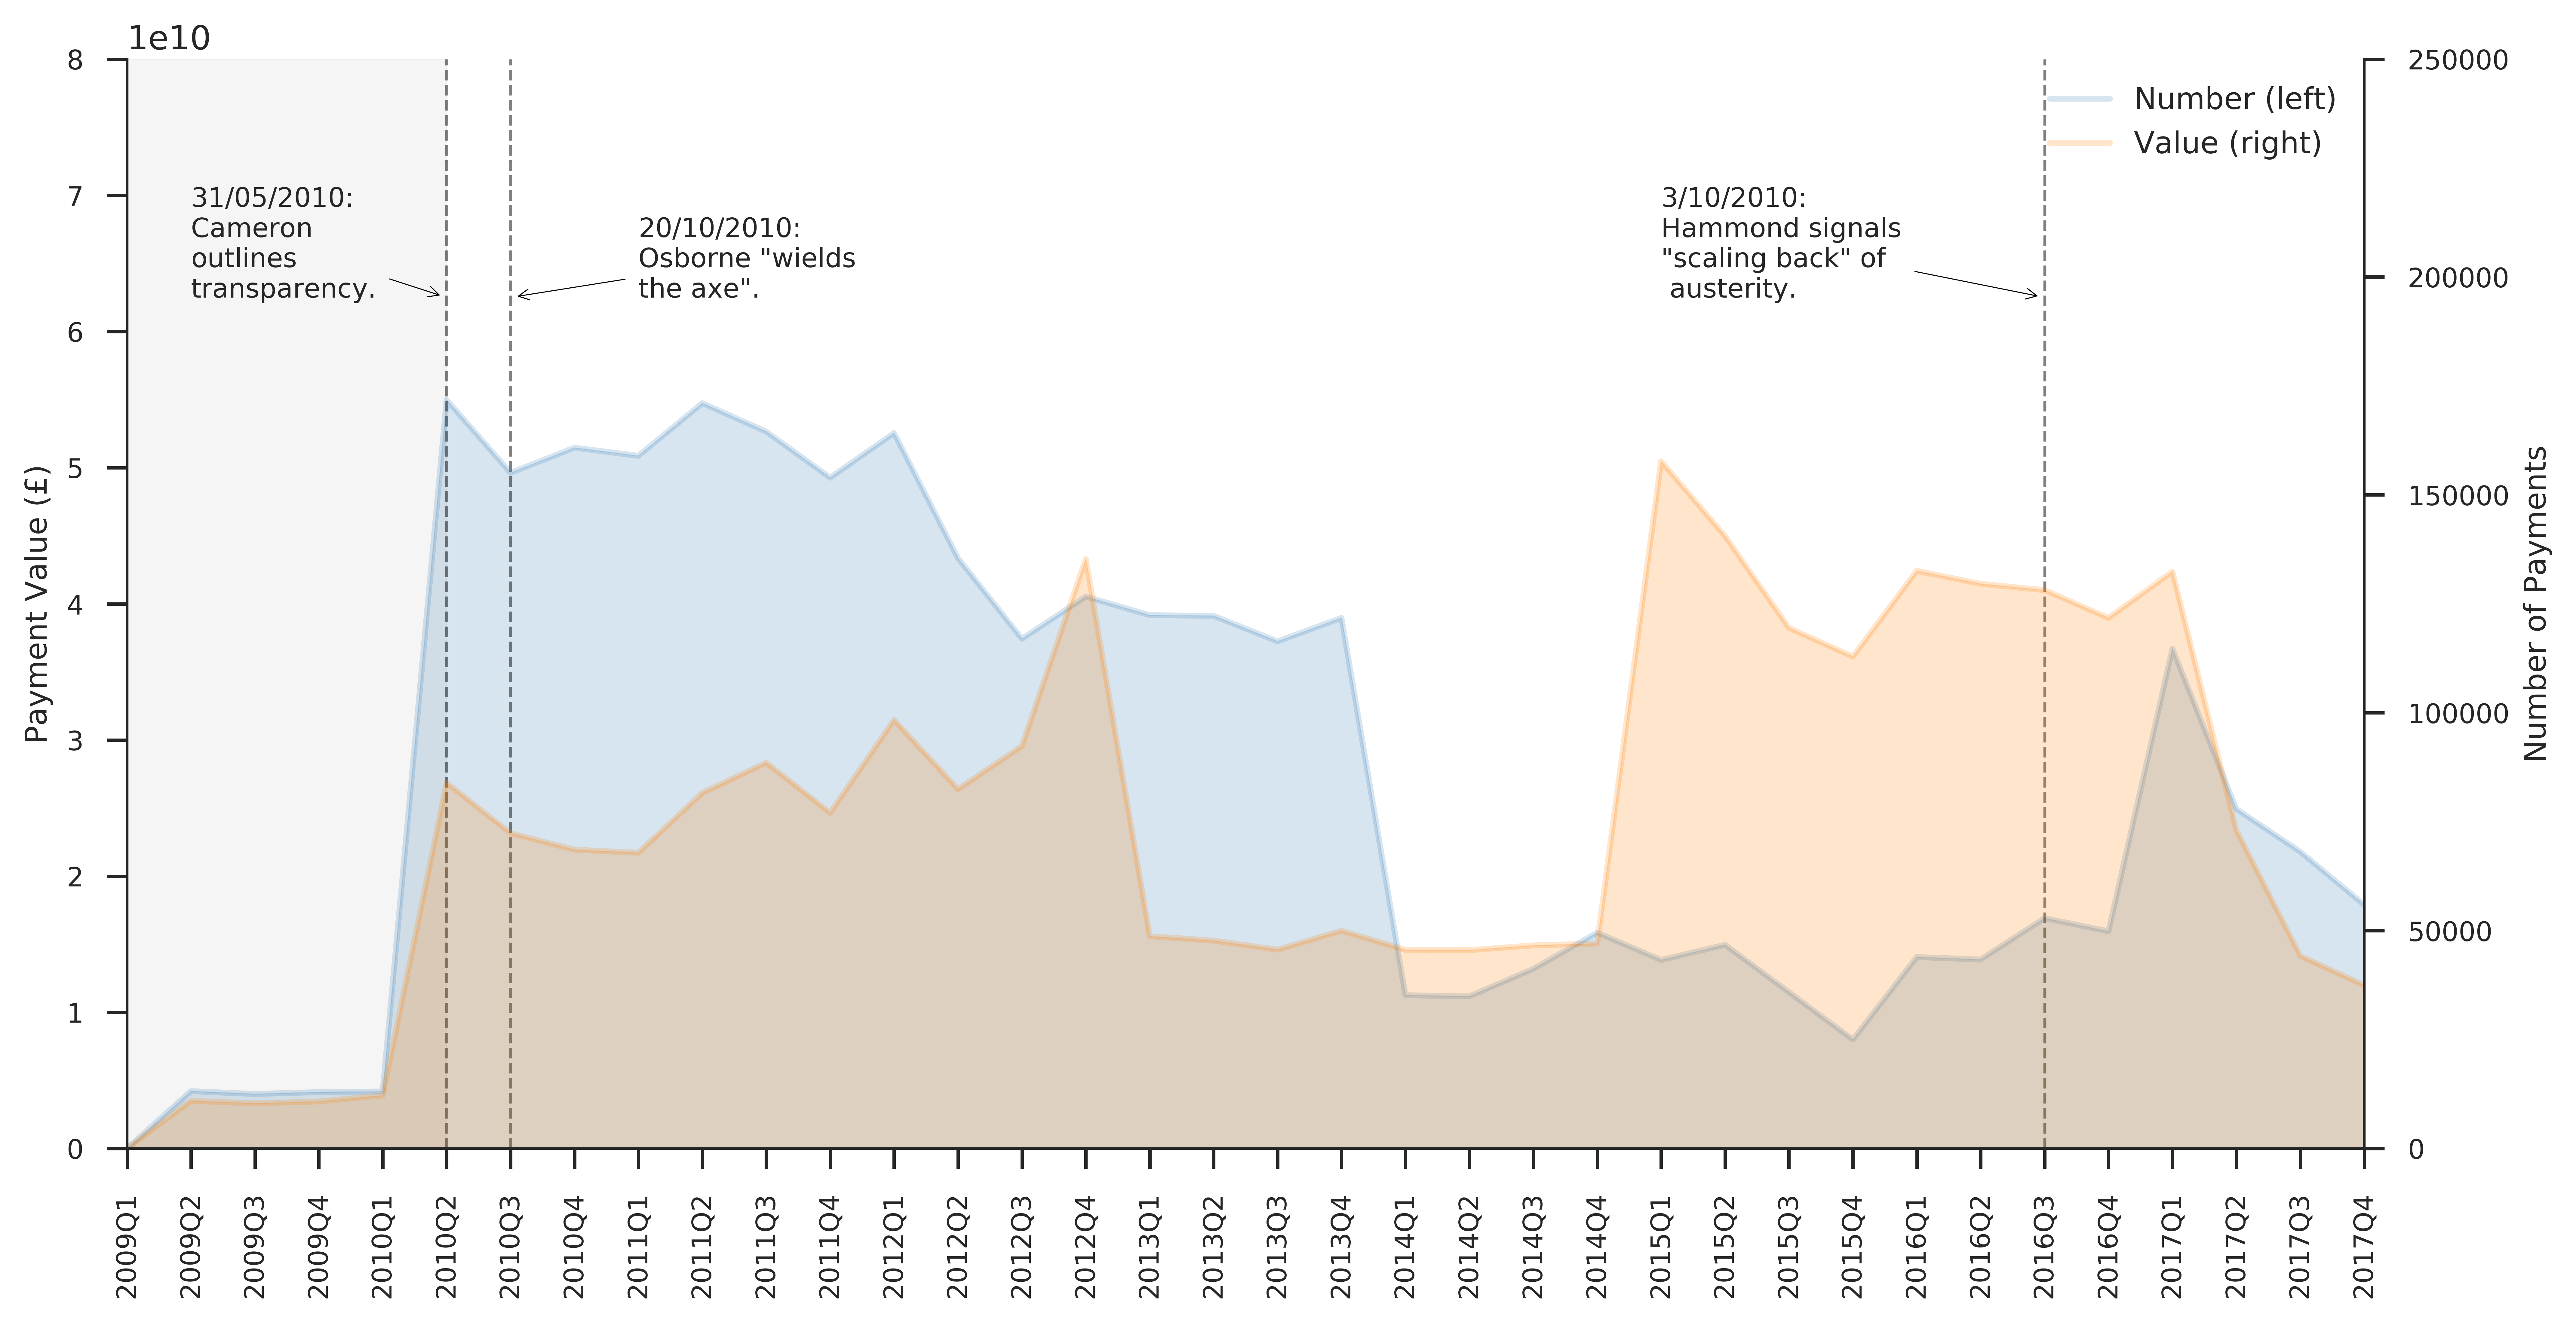

In [4]:
yearmonthlist = []
timely_df = pd.DataFrame(columns=['Number of Payments', 'Value of Payments'])
numberpayments = 0
valuepayments = 0
for year in list(range(2009, 2018)):
    timely_df.at[str(year) + 'Q1'] = len(payments[((
        payments['date'].dt.month == 1) |
        (payments['date'].dt.month == 2) |
        (payments['date'].dt.month == 3)) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q1', 'Number of Payments'] = payments[((
        payments['date'].dt.month == 1) |
        (payments['date'].dt.month == 2) |
        (payments['date'].dt.month == 3)) &
        (payments['date'].dt.year == year)]['amount'].sum()
    timely_df.at[str(year) + 'Q2'] = len(payments[((
        payments['date'].dt.month == 4) |
        (payments['date'].dt.month == 5) |
        (payments['date'].dt.month == 6)) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q2', 'Number of Payments'] = payments[((
        payments['date'].dt.month == 4) |
        (payments['date'].dt.month == 5) |
        (payments['date'].dt.month == 6)) &
        (payments['date'].dt.year == year)]['amount'].sum()
    timely_df.at[str(year) + 'Q3'] = len(payments[((
        payments['date'].dt.month == 7) |
        (payments['date'].dt.month == 8) |
        (payments['date'].dt.month == 9)) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q3', 'Number of Payments'] = payments[((
        payments['date'].dt.month == 7) |
        (payments['date'].dt.month == 8) |
        (payments['date'].dt.month == 9)) &
        (payments['date'].dt.year == year)]['amount'].sum()
    timely_df.at[str(year) + 'Q4'] = len(payments[((
        payments['date'].dt.month == 10) |
        (payments['date'].dt.month == 11) |
        (payments['date'].dt.month == 12)) &
        (payments['date'].dt.year == year)])
    timely_df.at[str(year) + 'Q4', 'Number of Payments'] = payments[((
        payments['date'].dt.month == 10) |
        (payments['date'].dt.month == 11) |
        (payments['date'].dt.month == 12)) &
        (payments['date'].dt.year == year)]['amount'].sum()
sns.set(style='ticks')
tester = timely_df.reset_index()
fig = plt.figure(figsize=(12, 6), dpi=800)
axC = fig.add_subplot(1, 1, 1)
axtest = axC.twinx()
ax_2a = tester[['Number of Payments']].plot(kind='area', ax=axC,
                                            color='#377eb8',
                                            legend=False,
                                            alpha=0.2)
ax_2b = tester[['Value of Payments']].plot(kind='area', ax=axtest,
                                           color='#ff7f00',
                                           legend=False,
                                           alpha=0.2)
ax_2a.set_xticks(tester.index)
ax_2a.set_xticklabels(tester['index'], rotation=90)
ymin, ymax = ax_2a.get_ylim()

ax_2a.vlines(x=5, ymin=ymin, ymax=80000000000, color='k', linestyle='--',
             alpha=0.5, linewidth=0.85)
ax_2a.annotate('31/05/2010:\nCameron\noutlines\ntransparency.',
               xy=(5, 62500000000), xytext=(1, 62500000000),
               arrowprops=dict(facecolor='black', arrowstyle="->"), size=8)
ax_2a.vlines(x=6, ymin=ymin, ymax=80000000000, color='k',
             linestyle='--', alpha=0.5, linewidth=0.85)
ax_2a.annotate('20/10/2010:\nOsborne "wields\nthe axe".', xy=(6, 62500000000),
               xytext=(8, 62500000000),
               arrowprops=dict(facecolor='black', arrowstyle="->"), size=8)
ax_2a.vlines(x=30, ymin=ymin, ymax=80000000000, color='k',
             linestyle='--', alpha=0.5, linewidth=0.85)
ax_2a.annotate('3/10/2010:\nHammond signals\n"scaling back" of\n austerity.',
               xy=(30, 62500000000), xytext=(24, 62500000000),
               arrowprops=dict(facecolor='black', arrowstyle="->"), size=8)
ax_2a.set_ylim(0, 80000000000)
ax_2b.set_ylim(0, 250000)
ax_2a.spines['top'].set_visible(False)
ax_2b.spines['top'].set_visible(False)
ax_2a.axvspan(0, 5, alpha=0.075, color='grey')
ax_2a.margins(0.0)
ax_2a.spines['right'].set_visible(False)
ax_2a.spines['left'].set_visible(False)
ax_2a.set_ylabel("Payment Value (£)", size=9)
ax_2b.set_ylabel("Number of Payments", size=9)
for axis in ['top', 'bottom', 'left', 'right']:
    ax_2a.spines[axis].set_linewidth(0.75)
    ax_2b.spines[axis].set_linewidth(0.75)
axC.plot(0, 0, '-r', color='#ff7f00', markersize=7, alpha=0.2,
         markeredgecolor='k', markeredgewidth=0.5)
leg = axC.legend(['Number (left)', 'Value (right)'],
                 fontsize=9, loc='upper right')
ax_2a.tick_params(labelsize=8)
ax_2b.tick_params(labelsize=8)
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'timeline.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'timeline.png')), bbox_inches='tight', dpi=800)

What do the matches look like? 

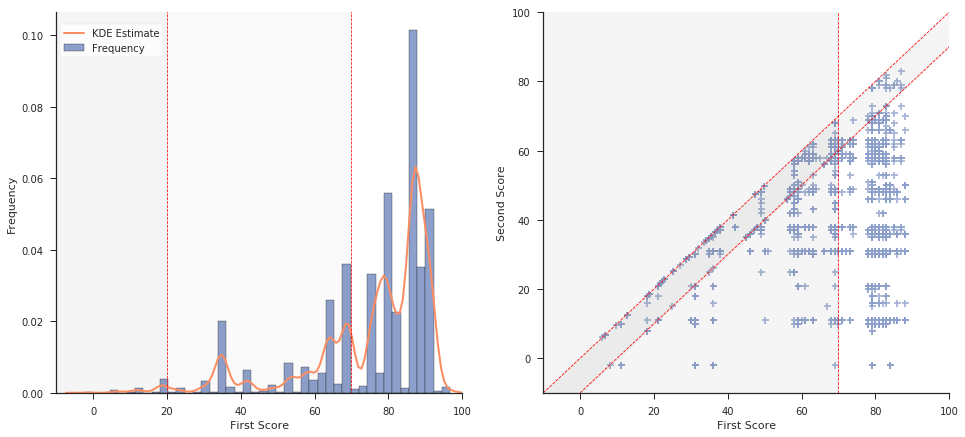

In [5]:
sns.set(style='ticks')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

h = sns.distplot(recon_sup[~pd.isnull(recon_sup['First Match'])]['First Score'],
                 bins=44,
                 kde_kws={"color": "#fc8d62",
                          "lw": 2, "label": "KDE Estimate",
                          "alpha": 1},
                 hist_kws={"color": "#8da0cb",
                           "alpha": 1, "label": "Frequency",
                           'edgecolor': 'k'},
                 ax=ax1)
h.set(ylabel="Frequency")
h.set_xlim(xmin=-10, xmax=100)
#h.set_ylim(ymin=0, ymax=0.16)
h.plot([20, 20], [-10, 100], color='r', linestyle='--', linewidth=0.75)
h.plot([70, 70], [-10, 100], color='r', linestyle='--', linewidth=0.75)
h.legend(loc='center left', bbox_to_anchor=(-0.004, 0.925),frameon=True)

#h.annotate('Reject', xy=(0, 0.145))
#h.annotate('Verify', xy=(45, 0.145))
#h.annotate('Accept', xy=(80, 0.145))
h.axvspan(-20, 20, alpha=0.08, color='grey')
h.axvspan(20, 70, alpha=0.04, color='grey')
g = sns.regplot(x="First Score", y="Second Score", data=recon_sup,
                fit_reg=False, ax=ax2, color='#8da0cb', marker='+')
g.set_xlim(xmin=-10, xmax=100)
g.set_ylim(ymin=-10, ymax=100)
r2 = patches.Rectangle((0, -20), 7.5, 200, color = "grey",  alpha=0.08)
t2 = mpl.transforms.Affine2D().rotate_deg(-45) + g.transData
r2.set_transform(t2)
g.add_patch(r2)
r1 = patches.Rectangle((70, -10), -80, 110, color="grey",  alpha=0.08)
g.add_patch(r1)
g.plot([-10, 100], [-10, 100], color='r', linestyle='--', linewidth=0.8)
g.plot([0, 100], [-10, 90], color='r', linestyle='--', linewidth=0.8)
g.plot([70, 70], [-10, 100], color='r', linestyle='--', linewidth=0.8)
sns.despine(right=True, top=True, ax=ax1)
sns.despine(right=True, top=True, ax=ax2)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch.pdf')), bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch.png')), bbox_inches='tight', dpi=800)

In [6]:
recon_clean = clean_matches(recon_sup, 'automated_safe')
recon_clean['company_number'] = recon_clean['Best ID'].str.replace('/companies/gb/','')
matched_clean = pd.merge(payments, recon_clean, how='left',
                         left_on='supplier',
                         right_on='RawSupplier').dropna(subset=['Best Match'])
print('We matched ' + str(len(matched_clean)) + ' out of ' + str(len(payments)) +
      ' payments in total (' + str(round(((len(matched_clean) /
                                           len(payments)) * 100), 2)) + '%).')
print('We matched £' + str(int(matched_clean['amount'].sum())) + ' out of ' +
      '£' + str(int(payments['amount'].sum())) +
      ' value in total (' + str(int(round(((matched_clean['amount'].sum() /
                                        payments['amount'].sum()) *
                                       100), 2))) + '%).')
print('We matched ' + str(len(matched_clean['supplier'].unique())) + ' out of ' +
      str(len(payments['supplier'].unique())) +
      ' unique suppliers in total (' +
      str(round(((len(matched_clean['supplier'].unique()) /
                  len(payments['supplier'].unique())) * 100), 2)) + '%).')

***Undertaking an automated safe reconciliation!***
We matched 1443251 out of 2718202 payments in total (53.1%).
We matched £118863976771 out of £998659968686 value in total (11%).
We matched 18960 out of 60581 unique suppliers in total (31.3%).


What companies are getting what?

In [7]:
sup_numpays = pd.DataFrame(matched_clean.groupby(
    ['Best Match']).size(), columns=['Number of Payments'])
sup_value = pd.DataFrame(pd.DataFrame(matched_clean.groupby(['Best Match'])[
                         'amount'].agg('sum'))).rename(
    columns={'amount': 'Value of Payments'})
sup_both = pd.concat([sup_value, sup_numpays], axis=1).reset_index()
recon_sup_for_match = recon_sup[['Best Match','Postcode','SIC Code','Type',
                                 'First Score',
                                 'Best ID']].drop_duplicates(subset='Best Match')
sup_both = pd.merge(sup_both, recon_sup_for_match, how='left',
                    left_on='Best Match', right_on='Best Match')
sup_both = sup_both.sort_values(ascending=False, by='Value of Payments')[0:20]
sup_both['ID'] = sup_both['Best ID'].str.replace('/companies/gb/', '')
sup_both['Best Match'] = sup_both['Best Match'].str.title()
sup_both = sup_both.set_index('Best Match')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace("[", '')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace(']', '')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace("'", "")
sup_both[['Value of Payments', 'Number of Payments',
          'Postcode', 'SIC Code', 'Type']].style

,Value of Payments,Number of Payments,Postcode,SIC Code,Type
Best Match,,,,,
Student Loans Company Limited,1.63631e+10,27,DL1 1RW,64929,ltd
British Broadcasting Corporation,1.19815e+10,178,nan,nan,royal-charter
Post Office Limited,9.72933e+09,1086,EC2Y 9AQ,"53100, 64999",ltd
Crossrail Limited,4.71902e+09,27,E14 5LQ,42120,ltd
Atos It Services Uk Limited,2.37021e+09,10763,WC1V 6EA,"26200, 62090, 70229, 86900",ltd
Airwave Solutions Limited,2.13497e+09,2004,SW1E 5LB,61900,ltd
Connect Plus (M25) Limited,2.0073e+09,2662,EN6 3NP,42110,ltd
Ibm United Kingdom Limited,1.86624e+09,4663,PO6 3AU,26200,ltd
The Arts Council Of England,1.67569e+09,61,nan,nan,royal-charter


How does that split across departments?

In [8]:
depts_df = pd.DataFrame(columns=['Files', 'Spend (£m)', 'Total Payments',
                                 '% to Prviate', 'Most Frequent PS Supplier'],
                        index=payments['dept'].unique())
for dept in matched_clean['dept'].unique():
    depts_df.loc[dept, 'Files'] = len(payments[payments['dept'] ==
                                               dept]['file'].unique())
    depts_df.loc[dept, 'Spend (£m)'] = round(
        payments[payments['dept'] == dept]['amount'].sum() / 1000000, 2)
    depts_df.loc[dept, 'Total Payments'] = len(
        payments[payments['dept'] == dept])
    depts_df.loc[dept,
                 'Most Frequent PS Supplier'] = matched_clean[matched_clean['dept']
                                                      == dept]['Best Match'].value_counts().sort_values(ascending=False).index[0]
    depts_df.loc[dept, '% to Prviate'] = round((matched_clean[matched_clean['dept'] ==
                                                        dept]['amount'].sum(
    ) / payments[payments['dept'] == dept]['amount'].sum()) * 100, 2)

depts_df.sort_values(by='Spend (£m)',ascending=False)[0:20]

,Files,Spend (£m),Total Payments,% to Prviate,Most Frequent PS Supplier
D. Health,47,417903,60873,1.4,EXPOTEL HOTEL RESERVATIONS LIMITED
D. Trans,84,149733,669722,20.62,INCHCAPE FLEET SOLUTIONS LIMITED
D. Educ,93,145867,89067,12.74,REDFERN TRAVEL LIMITED
Home Office,112,96104.4,113659,10.43,SPECIALIST COMPUTER CENTRES PLC
D. Int Dev,88,50030.8,144439,9.56,ADAM SMITH INTERNATIONAL LTD
DBIS,14,41388.9,27670,32.67,CAPITA BUSINESS SERVICES LTD
DWP,63,23509.7,1363930,27.14,XEROX (UK) LIMITED
DCMS,44,18271.4,4614,78.58,BRITISH BROADCASTING CORPORATION
DEFRA,62,18082.2,36603,19.34,IBM UNITED KINGDOM LIMITED
HMRC,95,12996.6,43359,28.41,TNT UK LIMITED


How does that split across SIC?

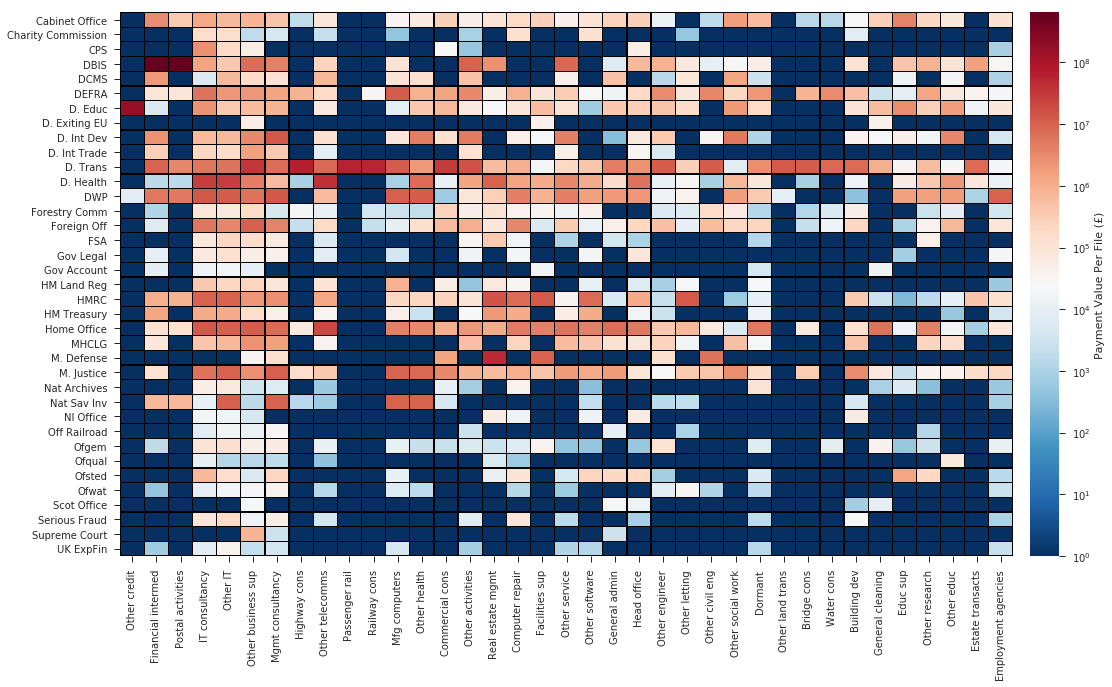

In [9]:
with open(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output',
                 'master', 'Single_SICs.tsv')), 'w') as sicfile:
    sicfile.write('amount\tdept\tsic\n')
    for index, row in matched_clean.iterrows():
        if pd.isnull(row['SIC Code']) is False:
            for sic in row['SIC Code'].split(','):
                sic = re.findall('\\b\\d+\\b', sic)[0]
                sicfile.write(str(row['amount']) + '\t' + 
                              row['dept'] + '\t' + str(sic)+'\n')
sicfile = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output',
                 'master', 'Single_SICs.tsv')), sep = '\t', encoding='latin-1')
sicfile = sicfile[sicfile['amount']>25000]
replacedict = pd.read_csv((os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'support', 'sic_renamer.csv'))),
                          header=None, dtype={0: str}).set_index(0).squeeze().to_dict()
for key, value in replacedict.items():
    sicfile['sic'] = sicfile['sic'].replace(int(key),value)
    
sup_value = pd.DataFrame(pd.DataFrame(matched_clean.groupby(['Best Match'])['amount'].agg('sum')))
uniquedepts = sicfile['dept'].unique()
top_sics = pd.DataFrame(sicfile.groupby(['sic'])['amount'].agg('sum')).sort_values(by='amount', ascending=False)[0:37].index
sicdept_df = pd.DataFrame(columns = top_sics, index = uniquedepts)
for dept in uniquedepts:
    for sic in list(sicdept_df):
        sicdept_df.loc[dept,sic] = (sicfile[(sicfile['sic']==sic) & (sicfile['dept']==dept)]['amount'].sum()/depts_df.loc[dept,'Files'])
fig, ax = plt.subplots(figsize=(16,10)) 
sicdept_df=sicdept_df.astype(float)
sicdept_df[sicdept_df <= 0] = 1
log_norm = LogNorm(vmin=sicdept_df.min().min(), vmax=sicdept_df.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(sicdept_df.min().min())), 1+math.ceil(math.log10(sicdept_df.max().max())))]
cbar_ax = fig.add_axes([.915, 0.125, .025, .755])
g = sns.heatmap(sicdept_df,linewidths=0.25,linecolor='k',cmap="RdBu_r",cbar_ax = cbar_ax, ax = ax,
                    norm=log_norm, cbar_kws={"ticks": cbar_ticks, 'label': 'Payment Value Per File (£)'})
g.set_ylabel('');
g.set_xlabel('');
fig = g.get_figure()
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'sic_dept_heatmap.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'sic_dept_heatmap.png')), bbox_inches='tight', dpi=800)

## Sociology

Load datasets first to reduce computational time

In [10]:
ch_psc = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'companies_house',
                 'psc_flatfile.tsv')),
    encoding="ISO-8859-1", sep='\t', error_bad_lines=False,
                    dtype={'company_number': str, 'address_line_1': str, 'address_line_2' : str,
       'locality':str,'postal_code':str, 'region':str,
       'country_of_residence':str,'etag':str,'kind':str,
       'links':str,'name':str, 'forename':str,
       'middle_name':str, 'surname':str,
       'title':str, 'nationality':str,
       'natures_of_control':str,'date_of_birth':object})

ch_officers = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'companies_house',
                 'ch_full_officers.tsv')),
    encoding="ISO-8859-1", sep='\t', error_bad_lines=False, 
                          warn_bad_lines = False)

## Age

In [11]:
#ch_officers_age = ch_officers[ch_officers['Date of Birth'].notnull()]
#ch_officers_age['Date of Birth'] = ch_officers_age['Date of Birth'].apply(
#    lambda x: dict(eval(x)))
#ch_officers_age = pd.concat(
#    [ch_officers_age, ch_officers_age['Date of Birth'].apply(pd.Series)], axis=1)
#ch_officers_age = ch_officers_age[(ch_officers_age['year'] >= 1918)
#                          & (ch_officers_age['year'] <= 2018)]
#ch_officers_age['Cleaned Date'] = ch_officers_age['year'].map(
#    str) + '-' + ch_officers_age['month'].map(str) + '-01'
#ch_officers_age['Age'] = pd.to_datetime(
#    'today').year - pd.to_datetime(ch_officers_age['Cleaned Date']).dt.year
#ch_officers_age = ch_officers_age[ch_officers_age['Age'].notnull()]
#
#recon_officers_age = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
#                                ch_officers_age, how='left', left_on='company_number',
#                                right_on='CompanyNumber')
#recon_officers_age = recon_officers_age[recon_officers_age['Age'].notnull()]

In [12]:
#ch_psc_age = ch_psc[ch_psc['date_of_birth'].notnull()]
#ch_psc_age['date_of_birth'] = ch_psc_age['date_of_birth'].apply(lambda x : dict(eval(x)))
#ch_psc_age = pd.concat([ch_psc_age, ch_psc_age['date_of_birth'].apply(pd.Series )], axis=1)
#ch_psc_age = ch_psc_age[(ch_psc_age['year']>=1900) & (ch_psc_age['year']<=2018)]
#ch_psc_age['Cleaned Date'] = ch_psc_age['year'].map(str) + '-' + ch_psc_age['month'].map(str) + '-01'
#ch_psc_age['Age'] = pd.to_datetime('today').year - pd.to_datetime(ch_psc_age['Cleaned Date']).dt.year
#ch_psc_age = ch_psc_age[ch_psc_age['Age'].notnull()]
#
#recon_psc_age = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
#                                ch_psc_age, how='left', left_on='company_number',
#                                right_on='company_number')
#recon_psc_age = recon_psc_age[recon_psc_age['Age'].notnull()]

In [13]:
#sns.set(style='ticks')
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
#
#g = recon_officers_age['Age'].hist(bins=range(0,100),normed=True,alpha=0.35, color='#377eb8',edgecolor='gray',grid=False, ax=ax1,label='Reconciled Officers')
#g = ch_officers_age['Age'].hist(bins=range(0,100),normed=True,alpha=0.35, color= '#ff7f00', edgecolor='gray', grid=False, ax=ax1,label='All Officers')
#ax1.set_ylabel("Normalized Frequency",fontsize=12)
#ax1.set_xlabel("Age",fontsize=12)
#g.legend(loc='upper left',edgecolor='k',frameon=True)
#
#h = recon_psc_age['Age'].hist(bins=range(0,100),normed=True,alpha=0.35, color='#377eb8',edgecolor='gray',grid=False, ax=ax2, label='Reconciled PSC')
#h = ch_psc_age['Age'].hist(bins=range(0,100),normed=True,alpha=0.35, color='#ff7f00',edgecolor='gray',grid=False, ax=ax2, label='All PSC')
#ax2.set_ylabel("Normalized Frequency",fontsize=12)
#ax2.set_xlabel("Age",fontsize=12)
#h.legend(loc='upper left',edgecolor='k',frameon=True)
#sns.despine()
#
#f.subplots_adjust(hspace=10)
#f.savefig(os.path.abspath(
#    os.path.join('__file__', '../..','compile','figures',
#                 'officers_and_psc_age.pdf')), bbox_inches='tight')
#f.savefig(os.path.abspath(
#    os.path.join('__file__', '../..','compile','figures',
#                 'officers_and_psc_age.png')), bbox_inches='tight', dpi=800)
#
#
#print(ch_officers_age['Age'].mean())
#print(recon_officers_age['Age'].mean())
#print(ch_psc_age['Age'].mean())
#print(recon_psc_age['Age'].mean())

## Gender

In [14]:
def clean_officer_names(x):
    try:
        if len(x.split(' '))>=1:
            return x.split(' ')[1]
    except IndexError:
        pass

ch_officers_gen = ch_officers[ch_officers['Name'].notnull()]
ch_officers_gen['Forename'] = ch_officers_gen['Name'].map(
    lambda x: clean_officer_names(x))
ch_officers_gen['CleanGender'] = ch_officers_gen['Forename'].map(
    lambda x: gendet.get_gender(x))
ch_officers_gen['MaleFemale'] = ch_officers_gen['CleanGender'].str.replace(
    'mostly_', '')
ch_officers_gen['isfemale'] = np.where(
    ch_officers_gen['MaleFemale'] == 'female', 1, 0)
ch_officers_gen = ch_officers_gen[(ch_officers_gen['MaleFemale'] == 'male') | (
    ch_officers_gen['MaleFemale'] == 'female')]

recon_officers_gen = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_gen, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_gen = recon_officers_gen[(recon_officers_gen['MaleFemale'] == 'male') | (
    recon_officers_gen['MaleFemale'] == 'female')]

print(ch_officers_gen['isfemale'].mean())
print(recon_officers_gen['isfemale'].mean())
print(len(recon_officers_gen))
print(len(recon_clean['company_number'].drop_duplicates()))
print(len(recon_officers_gen['company_number'].drop_duplicates()))
print(len(ch_officers['CompanyNumber'].drop_duplicates()))

0.2950283963208784
0.28172288998481126
53329
17874
3351
806736


In [15]:
def clean_psc_names(x):
    if ('ltd' not in x.lower()) and ('limited' not in x.lower()):
        x=x.replace('.','').strip()
        x=x.replace('Mrs ','').strip()
        x=x.replace('Mr ','').strip()
        x=x.replace('Wing Commander','').strip()
        x=x.replace('Miss ','').strip()
        x=x.replace('Dr ','').strip()
        x=x.replace('Ms ','').strip()
        if len(x.split(' ')[0].title())>2:
            return x.split(' ')[0].title()

ch_psc_gen = ch_psc[ch_psc['name'].notnull()]
ch_psc_gen['Forename'] = ch_psc_gen['name'].map(
    lambda x: clean_psc_names(x))
ch_psc_gen['CleanGender'] = ch_psc_gen['Forename'].map(
    lambda x: gendet.get_gender(x))
ch_psc_gen['MaleFemale'] = ch_psc_gen['CleanGender'].str.replace(
    'mostly_', '')
ch_psc_gen['isfemale'] = np.where(
    ch_psc_gen['MaleFemale'] == 'female', 1, 0)
ch_psc_gen = ch_psc_gen[(ch_psc_gen['MaleFemale'] == 'male') | (
    ch_psc_gen['MaleFemale'] == 'female')]

recon_psc_gen = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_gen, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_gen = recon_psc_gen[(recon_psc_gen['MaleFemale'] == 'male') | (
    recon_psc_gen['MaleFemale'] == 'female')]

print(ch_psc_gen['isfemale'].mean())
print(recon_psc_gen['isfemale'].mean())
print(len(recon_psc_gen))
print(len(recon_clean['company_number'].drop_duplicates()))
print(len(recon_psc_gen['company_number'].drop_duplicates()))
print(len(ch_psc['company_number'].drop_duplicates()))

0.27849980412029207
0.2793660658794282
16090
17874
8891
4342569


## Nationalities

In [16]:
def clean_nationalities(x):
    x = x.lower().replace('english','british')
    x = x.lower().replace('scottish','british')
    x = x.lower().replace('welsh','british')
    x = x.lower().replace('northern irish','british')
    x = x.lower().replace('united kingdom', 'british')
    x = x.lower().replace('.','')
    x = x.lower().replace(',','')
    if x.lower()[0:2] == 'uk':
        x = 'british'
    return x.title()

ch_psc_nat = ch_psc[ch_psc['nationality'].notnull()]
ch_psc_nat['nationality'] = ch_psc_nat['nationality'].map(lambda x: clean_nationalities(x))
len_ch_psc_nat = len(ch_psc_nat[ch_psc_nat['nationality'].notnull()])
ch_psc_nat_pcs = ch_psc_nat['nationality'].value_counts().divide(len_ch_psc_nat/100)
ch_psc_nat_pcs = ch_psc_nat_pcs.sort_values(ascending=False)

recon_psc_nat = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_nat, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_nat = recon_psc_nat[recon_psc_nat['nationality'].notnull()]
recon_psc_nat['nationality'] = recon_psc_nat['nationality'].map(lambda x: clean_nationalities(x))
len_recon_psc_nat = len(recon_psc_nat[recon_psc_nat['nationality'].notnull()])
recon_psc_nat_pcs = recon_psc_nat['nationality'].value_counts().divide(len_recon_psc_nat/100)
recon_psc_nat_pcs = recon_psc_nat_pcs.sort_values(ascending=False)

In [17]:
ch_officers_nat = ch_officers[ch_officers['Nationality'].notnull()]
ch_officers_nat['Nationality'] = ch_officers_nat['Nationality'].map(lambda x: clean_nationalities(x))
len_ch_officers_nat = len(ch_officers_nat[ch_officers_nat['Nationality'].notnull()])
ch_officers_nat_pcs = ch_officers_nat['Nationality'].value_counts().divide(len_ch_officers_nat/100)
ch_officers_nat_pcs = ch_officers_nat_pcs.sort_values(ascending=False)

recon_officers_nat = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_nat, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_nat = recon_officers_nat[recon_officers_nat['Nationality'].notnull()]
recon_officers_nat['Nationality'] = recon_officers_nat['Nationality'].map(lambda x: clean_nationalities(x))
len_recon_officers_nat = len(recon_officers_nat[recon_officers_nat['Nationality'].notnull()])
recon_officers_nat_pcs = recon_officers_nat['Nationality'].value_counts().divide(len_recon_officers_nat/100)
recon_officers_nat_pcs = recon_officers_nat_pcs.sort_values(ascending=False)

## Countries of Residence

In [18]:
def clean_countries(x):
    x = x.lower().replace('england','united kingdom')
    x = x.lower().replace('scotland','united kingdom')
    x = x.lower().replace('wales','united kingdom')
    x = x.lower().replace('northern ireland','united kingdom')
    x = x.lower().replace('britain','united kingdom')
    x = x.lower().replace('.','')
    x = x.lower().replace(',','')
    if x.lower()[0:2] == 'gb':
        x = 'united kingdom'
    return x.title()

ch_psc_cou = ch_psc[ch_psc['country_of_residence'].notnull()]
ch_psc_cou['country_of_residence'] = ch_psc_cou['country_of_residence'].map(lambda x: clean_countries(x))
len_ch_psc_cou = len(ch_psc_cou[ch_psc_cou['country_of_residence'].notnull()])
ch_psc_cou_pcs = ch_psc_cou['country_of_residence'].value_counts().divide(len_ch_psc_cou/100)
ch_psc_cou_pcs = ch_psc_cou_pcs.sort_values(ascending=False)


recon_psc_cou = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_cou, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_cou = recon_psc_cou[recon_psc_cou['country_of_residence'].notnull()]
len_recon_psc_cou = len(recon_psc_cou[recon_psc_cou['country_of_residence'].notnull()])
recon_psc_cou_pcs = recon_psc_cou['country_of_residence'].value_counts().divide(len_recon_psc_cou/100)
recon_psc_cou_pcs = recon_psc_cou_pcs.sort_values(ascending=False)

In [19]:
ch_officers_cou = ch_officers[ch_officers['Country of Residence'].notnull()]
ch_officers_cou['Country of Residence'] = ch_officers_cou['Country of Residence'].map(lambda x: clean_countries(x))
len_ch_officers_cou = len(ch_officers_cou[ch_officers_cou['Country of Residence'].notnull()])
ch_officers_cou_pcs = ch_officers_cou['Country of Residence'].value_counts().divide(len_ch_officers_cou/100)
ch_officers_cou_pcs = ch_officers_cou_pcs.sort_values(ascending=False)

recon_officers_cou = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_cou, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_cou = recon_officers_cou[recon_officers_cou['Country of Residence'].notnull()]
len_recon_officers_cou = len(recon_officers_cou[recon_officers_cou['Country of Residence'].notnull()])
recon_officers_cou_pcs = recon_officers_cou['Country of Residence'].value_counts().divide(len_recon_officers_cou/100)
recon_officers_cou_pcs = recon_officers_cou_pcs.sort_values(ascending=False)

## plot residences and nationalities

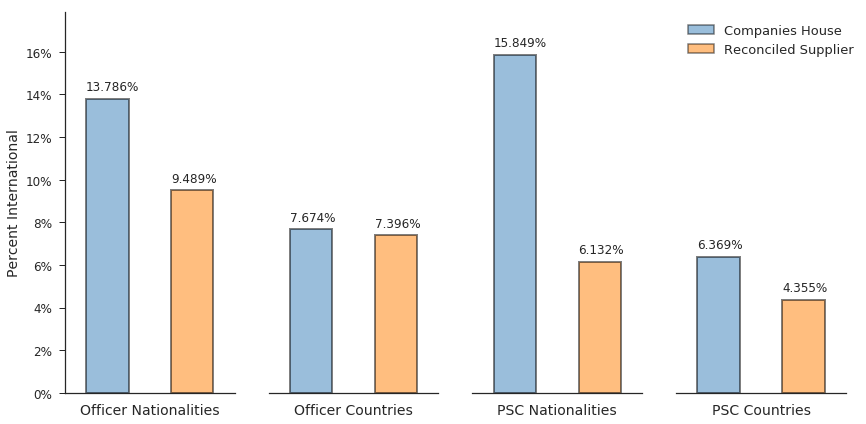

In [20]:
import matplotlib.patches as mpatches

df_resi_nat = pd.DataFrame(index=['CH','Recon'],
                           columns=['Officer Countries',
                                    'Officer Nationalities',
                                    'PSC Countries',
                                    'PSC Nationalities'])

df_resi_nat.loc['Recon','Officer Countries'] = 100-recon_officers_cou_pcs['United Kingdom']
df_resi_nat.loc['CH','Officer Countries'] = 100-ch_officers_cou_pcs['United Kingdom']
df_resi_nat.loc['Recon','PSC Countries'] = 100-recon_psc_cou_pcs['United Kingdom']
df_resi_nat.loc['CH','PSC Countries'] = 100-ch_psc_cou_pcs['United Kingdom']
df_resi_nat.loc['Recon','Officer Nationalities'] = 100-recon_officers_nat_pcs['British']
df_resi_nat.loc['CH','Officer Nationalities'] = 100-ch_officers_nat_pcs['British']
df_resi_nat.loc['Recon','PSC Nationalities'] = 100-recon_psc_nat_pcs['British']
df_resi_nat.loc['CH','PSC Nationalities'] = 100-ch_psc_nat_pcs['British']



fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(14,7))
sns.set_style("ticks")

a = df_resi_nat['Officer Nationalities'].plot(kind='bar',
                                              ax=axes[0],
                                              color=['#377eb8','#ff7f00'],
                                              alpha=0.5,
                                              edgecolor='k',
                                              linewidth=2)
b = df_resi_nat['Officer Countries'].plot(kind='bar',
                                          ax=axes[1],
                                          color=['#377eb8','#ff7f00'],
                                          alpha=0.5,
                                          edgecolor='k',
                                          linewidth=2)
c = df_resi_nat['PSC Nationalities'].plot(kind='bar',
                                          ax=axes[2],
                                          color=['#377eb8','#ff7f00'],
                                          alpha=0.5,
                                          edgecolor='k',
                                          linewidth=2)
d = df_resi_nat['PSC Countries'].plot(kind='bar',
                                      ax=axes[3],
                                      color=['#377eb8','#ff7f00'],
                                      alpha=0.5,
                                      edgecolor='k',
                                      linewidth=2,
                                      legend=True)


CH = mpatches.Patch(facecolor='#377eb8', label='Companies House',alpha=0.5,edgecolor='k',linewidth=1.5)
Recon = mpatches.Patch(facecolor='#ff7f00', label='Reconciled Supplier',alpha=0.5,edgecolor='k',linewidth=1.5)
plt.legend(handles=[CH,Recon], loc=2,fontsize=13, edgecolor='k')

a.set_xlabel("Officer Nationalities",fontsize=14,labelpad=10)
b.set_xlabel("Officer Countries",fontsize=14,labelpad=10)
c.set_xlabel("PSC Nationalities",fontsize=14,labelpad=10)
d.set_xlabel("PSC Countries",fontsize=14,labelpad=10)

for axy in [a,b,c,d]:
    axy.set_ylim(0, df_resi_nat.max().max()+2)
    axy.axes.get_xaxis().set_ticks([])
    for p in axy.patches:
        axy.annotate(str(round(p.get_height(),3))+'%', (p.get_x(), p.get_height() + 0.4))
    if axy!=a:
        sns.despine(ax=axy, left=True, bottom = False, right = True)
        #axy.yaxis.set_tick_position('none') 
        axy.axes.get_yaxis().set_visible(False)
    else:
        sns.despine(ax=axy, left=False, bottom = False, right = True)
        axy.set_ylabel("Percent International",fontsize=14)
        vals = axy.get_yticks()
        axy.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals],fontsize=12)

fig.subplots_adjust(hspace=25)
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'countries_and_nationalities.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'countries_and_nationalities.png')), bbox_inches='tight', dpi=800)

## Occupations

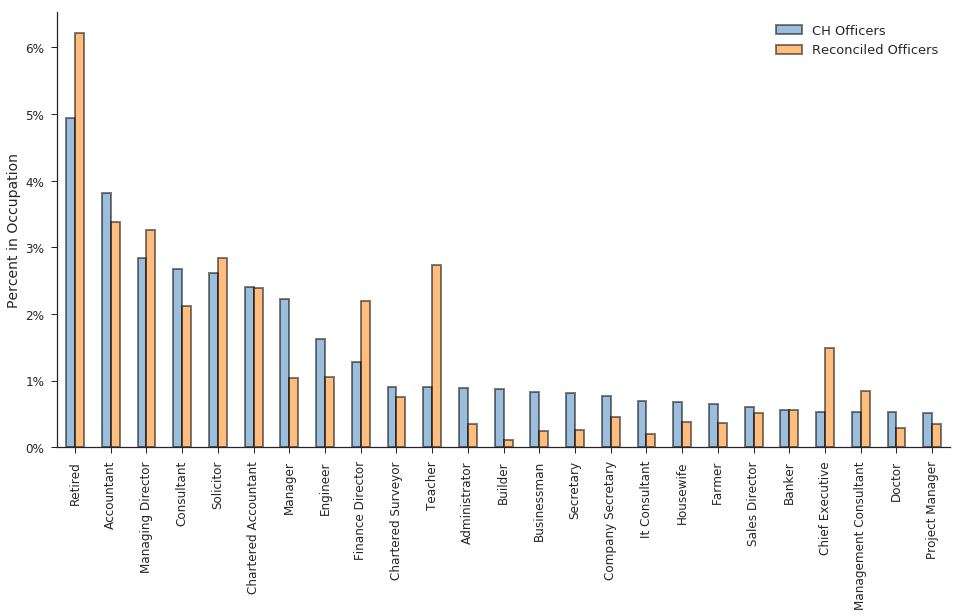

In [22]:
def clean_occupations(x):
    x = x.replace('.','')
    x = x.replace(',','')
    return x.title()

ch_officers_occ = ch_officers[ch_officers['Occupation'].notnull()]
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='Director']
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='Company Director']
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='None']
ch_officers_occ['Occupation'] = ch_officers_occ['Occupation'].map(lambda x: clean_occupations(x))
len_ch_officers_occ = len(ch_officers_occ[ch_officers_occ['Occupation'].notnull()])
ch_officers_occ_pcs = ch_officers_occ['Occupation'].value_counts().divide(len_ch_officers_occ/100)
ch_officers_occ_pcs = ch_officers_occ_pcs.sort_values(ascending=False)

recon_officers_occ = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_occ, how='left', left_on='company_number',
                                right_on='CompanyNumber')
len_recon_officers_occ = len(recon_officers_occ[recon_officers_occ['Occupation'].notnull()])
recon_officers_occ_pcs = recon_officers_occ['Occupation'].value_counts().divide(len_recon_officers_occ/100)
recon_officers_occ_pcs = recon_officers_occ_pcs.sort_values(ascending=False)

both_officers_occ_pcs = pd.merge(pd.DataFrame(ch_officers_occ_pcs),
                                 pd.DataFrame(recon_officers_occ_pcs),
                                 left_index=True, right_index=True)
both_officers_occ_pcs = both_officers_occ_pcs.rename({'Occupation_x':'CH Officers',
                                                      'Occupation_y': 'Reconciled Officers'},axis=1)
sns.set_style("ticks")
a = both_officers_occ_pcs[0:25].plot(kind='bar', figsize=(16,8),
                                     color=['#377eb8','#ff7f00'],
                                     alpha=0.5,
                                     edgecolor='k',
                                     linewidth=2)
a.set_ylabel("Percent in Occupation",fontsize=14)
vals = a.get_yticks()
a.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals],fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(loc='upper right',fontsize=13, edgecolor='k')
sns.despine()

fig = a.get_figure()

fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officer_occupations.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officer_occupations.png')), bbox_inches='tight', dpi=800)
